In [24]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PyQt5
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# Load data
df = pd.read_excel("data/Realized Schedule 20210101-20220208.xlsx")
# Remove rows with missing values
df.dropna(inplace=True)

print(df.head())

         ScheduleTime Airline  FlightNumber Destination AircraftType  \
0 2021-01-01 06:35:00      IA           874         DEN          73W   
1 2021-01-01 10:35:00      JZ           818         YHM          AT7   
2 2021-01-01 12:05:00      IA           876         DEN          73W   
3 2021-01-01 13:20:00      CN           514         EST          AT7   
4 2021-01-01 14:20:00      LJ          3140         DEN          32A   

  FlightType Sector  SeatCapacity  LoadFactor  
0          J     US           142    0.408451  
1          J     CA            74    0.189189  
2          J     US           142    0.570423  
3          J     US            72    0.333333  
4          J     US           186    0.204301  


### Analysis of the attributes

In [9]:
airlines = df['Airline'].unique()
print("Num airlines :", len(airlines))

flightnum = df['FlightNumber'].unique()
print("Num flight num :", len(flightnum))

aircraft = df['AircraftType'].unique()
print("Num aircraft type :", len(aircraft))

flighttype = df['FlightType'].unique()
print("Num flight type :", len(flighttype))

sectors = df['Sector'].unique()
print("Num sectors :", len(sectors))

seatcap = df['SeatCapacity'].unique()
print("Num seat capacities :", len(seatcap))

dest = df['Destination'].unique()
print("Num destinations :", len(dest))

Num airlines : 95
Num flight num : 807
Num aircraft type : 56
Num flight type : 3
Num sectors : 12
Num seat capacities : 132
Num destinations : 230


In [18]:
print(flighttype)
print(df[df['FlightType']=='G'])
print("We have one Flight with incorrect flight type")

['J' 'C' 'G']
             ScheduleTime Airline  FlightNumber Destination AircraftType  \
35822 2022-02-06 19:30:00      OF           575         OTH          32Q   

      FlightType Sector  SeatCapacity  LoadFactor  
35822          G     US           160     0.45625  
We have one Flight with incorrect flight type


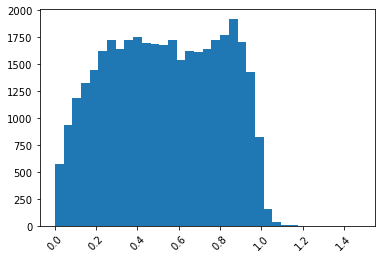

In [27]:
count = df['LoadFactor'].count()
bn = int(1 + 3.322*np.log(count))

plt.hist(df['LoadFactor'], bins = bn)
plt.xticks(rotation=45)
plt.set_title("Histogram of load factors over all flights")
plt.show()

In [30]:
# Load data
data = pd.read_excel("data/Realized Schedule 20210101-20220208.xlsx")

#############################
########Preprocessing########
#############################

# Remove rows with missing values
df = data.dropna()

# Remove row with flight type G
df = df[df["FlightType"] != "G"]


#Convert schedule time to different columns
# Include month, year, day and weekday in the dataset
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.year.rename("Year")], axis=1)
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.month.rename("Month")], axis=1)
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.isocalendar().week.rename("Week")], axis=1) # Remove isocalendar if error
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.day.rename("Day")], axis=1)
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.weekday.rename("Weekday")], axis=1)
df = pd.concat([df, pd.to_datetime(df.ScheduleTime).dt.hour.rename("Hour")], axis=1)

# Include dummy variables for categorical features
cols = ["Airline", "Destination", "FlightType", "Sector"]
col_prefix = ["AIR", "DEST", "FLT", "SECT"]
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
cols_to_drop = ["FlightNumber", "AircraftType", "ScheduleTime", "Weekday"]

for i, col in enumerate(cols):
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col_prefix[i])], axis=1)

weekday_df = pd.get_dummies(df.Weekday)
weekday_df.columns = weekdays

df = pd.concat([df, weekday_df], axis=1)

df.drop(cols, axis=1, inplace=True)
df.drop(cols_to_drop, axis=1, inplace=True)

print(df.columns)
print(df.shape)



Index(['SeatCapacity', 'LoadFactor', 'Year', 'Month', 'Week', 'Day', 'Hour',
       'AIR_AY', 'AIR_BJ', 'AIR_BT',
       ...
       'SECT_QA', 'SECT_SG', 'SECT_US', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday'],
      dtype='object', length=353)
(36767, 353)


In [3]:
#####################Visualizations############
sector_count = data.groupby(by="Sector").size()
plt.bar(sector_count.index, sector_count)
plt.show()


In [4]:

sns.boxplot(x="Hour", y="LoadFactor", data=df)
plt.show()



In [5]:
plt.scatter(df["Hour"], df["LoadFactor"])
plt.show()



In [6]:
# Extract features and targets
X = df.drop(["LoadFactor"], axis=1)
y = df.LoadFactor

# Perform train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1405)

In [7]:
# Extract features using forward selection
forward_selection_features = forward_selection(X_train, y_train, num_of_features=10)
print(X_train.columns[forward_selection_features])

Index(['AIR_DO', 'Month', 'FLT_C', 'AIR_SH', 'DEST_YXU', 'AIR_KL', 'DEST_YLW',
       'AIR_SV', 'DEST_AIY', 'AIR_TN'],
      dtype='object')


In [13]:
# Perform linear regression with the forward selected features
X_forward_sel = X_train.iloc[:, forward_selection_features]
X_val_sel = X_val.iloc[:, forward_selection_features]
model = LinearRegression()
model.fit(X_forward_sel, y_train)
y_hat = model.predict(X_val_sel)
print(y_hat[:10])
print(y_val[:10].to_numpy())
RMSE = np.sqrt(np.mean((y_hat - y_val)**2))
print(f'RMSE for forward selected model is: {RMSE}')
print(f'Lengths:\nyhat: {len(y_hat)}, yval: {len(y_val)}')
# Visualize the results
plt.plot(y_val, 'bo')
plt.plot(y_hat, 'go')


[0.30864124 0.66121278 0.67805668 0.64436889 0.26898887 0.5938372
 0.54330552 0.38689613 0.38689613 0.66121278]
[0.24381625 0.81666667 0.29166667 0.89417989 0.26666667 0.80555556
 0.95       0.13333333 0.31111111 0.39583333]
RMSE for forward selected model is: 0.22408462795270456
Lengths:
 yhat: 9192, yval: 9192


In [9]:
# Ectract features using backward selection
model = LinearRegression()
f_selector = RFE(model, n_features_to_select=10, step=1)
f_selector.fit(X_train, y_train)
print(X.columns[f_selector.support_])

Index(['AIR_DU', 'AIR_GX', 'AIR_KO', 'AIR_VD', 'DEST_AMS', 'DEST_AXX',
       'DEST_FNK', 'DEST_SUD', 'DEST_ZNG', 'SECT_NL'],
      dtype='object')


In [14]:
backward_selected_features = X_train.columns[f_selector.support_]
print(backward_selected_features)
X_backward_sel = X_train.loc[:, backward_selected_features]
X_val_sel = X_val.loc[:, backward_selected_features]
model = LinearRegression()
model.fit(X_backward_sel, y_train)
y_hat = model.predict(X_val_sel)
print(y_hat[:10])
print(y_val[:10].to_numpy())
RMSE = np.sqrt(np.mean((y_hat - y_val)**2))
print(f'RMSE for forward selected model is: {RMSE}')
print(f'Lengths:\nyhat: {len(y_hat)}, yval: {len(y_val)}')




Index(['AIR_DU', 'AIR_GX', 'AIR_KO', 'AIR_VD', 'DEST_AMS', 'DEST_AXX',
       'DEST_FNK', 'DEST_SUD', 'DEST_ZNG', 'SECT_NL'],
      dtype='object')
[0.53122314 0.53122314 0.53122314 0.53122314 0.53122314 0.53122314
 0.53122314 0.53122314 0.53122314 0.53122314]
[0.24381625 0.81666667 0.29166667 0.89417989 0.26666667 0.80555556
 0.95       0.13333333 0.31111111 0.39583333]
RMSE for forward selected model is: 19236298143.204052
Lengths:
yhat: 9192, yval: 9192
